

# RNN for Time Series

RNNs are used for sequence modeling. This tutorial will look at a tome series data to be modeled and predicted using RNNs. 

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

## Data

Release: Advance Monthly Sales for Retail and Food Services  
Units:  Millions of Dollars, Not Seasonally Adjusted

Frequency:  Monthly

The value for the most recent month is an advance estimate that is based on data from a subsample of firms from the larger Monthly Retail Trade Survey. The advance estimate will be superseded in following months by revised estimates derived from the larger Monthly Retail Trade Survey. The associated series from the Monthly Retail Trade Survey is available at https://fred.stlouisfed.org/series/MRTSSM448USN

Information about the Advance Monthly Retail Sales Survey can be found on the Census website at https://www.census.gov/retail/marts/about_the_surveys.html

Suggested Citation:
U.S. Census Bureau, Advance Retail Sales: Clothing and Clothing Accessory Stores [RSCCASN], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/RSCCASN, November 16, 2019.

https://fred.stlouisfed.org/series/RSCCASN

In [2]:
df = pd.read_csv('RSCCASN.csv',index_col='DATE',parse_dates=True)

In [3]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [4]:
# Set name of column as 'Sales'. Use - df.columns 

df.columns = ['Sales']

df.head()

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


<AxesSubplot:xlabel='DATE'>

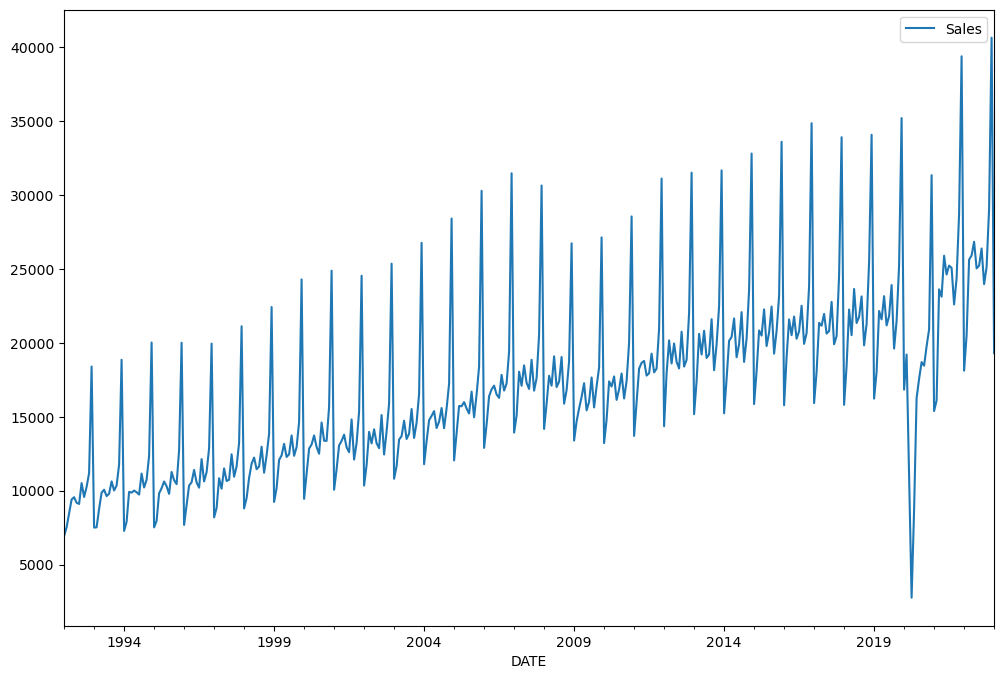

In [5]:
#Plot the data - Year vs Sales

df.plot(figsize=(12,8))

## Next we will do Train Test Split

We will use last 1.5 year (18 month) samples for testing. Rest is for training.

In [6]:
# Assign variable test size = 18

test_size = 18

In [7]:
# Store length of data in variable length.

data_length = len(df)
data_length

373

In [8]:
len(df)- 18

355

In [9]:
# store training size in varialable train_size 
# (Remember training size = total size - test_size)

train_size = data_length- test_size
train_size

355

In [10]:
# find the indexes of the test data. Remember, these are the last 18 indexes in the pandas dataframe.

test_index =  train_size

In [11]:
# separate train and test datasets.

train = df.iloc[:test_index]
test = df.iloc[test_index:]

In [12]:
# Print the size of the train data
# Print the size of the test data

print(train.size)
print(test.size)

355
18


In [13]:
# Print the train data

train

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2021-03-01,23616
2021-04-01,23115
2021-05-01,25886


In [14]:
# Print the test data

test

,Sales
DATE,
2021-08-01,25063
2021-09-01,22592
2021-10-01,24366
2021-11-01,28725
2021-12-01,39375
2022-01-01,18113
2022-02-01,20509
2022-03-01,25622
2022-04-01,25904


## Scale Data
between 0-1

In [15]:
from sklearn.preprocessing import MinMaxScaler

In [16]:
scaler = MinMaxScaler()
scaler.fit(train)

MinMaxScaler()

In [17]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [18]:
# Check if the data has been scaled properly

print(scaled_train.max())
print(scaled_test.max())
print(scaled_train.min())
print(scaled_test.min())

0.9999999999999999
1.1675042392477262
0.0
0.4733158624942192


# Time Series Generator

This class takes in a sequence of data-points gathered at
equal intervals, along with time series parameters such as
stride, length of history, etc., to produce batches for
training/validation.

#### Arguments
    data: Indexable generator (such as list or Numpy array)
        containing consecutive data points (timesteps).
        The data should be at 2D, and axis 0 is expected
        to be the time dimension.
    targets: Targets corresponding to timesteps in `data`.
        It should have same length as `data`.
    length: Length of the output sequences (in number of timesteps).
    sampling_rate: Period between successive individual timesteps
        within sequences. For rate `r`, timesteps
        `data[i]`, `data[i-r]`, ... `data[i - length]`
        are used for create a sample sequence.
    stride: Period between successive output sequences.
        For stride `s`, consecutive output samples would
        be centered around `data[i]`, `data[i+s]`, `data[i+2*s]`, etc.
    start_index: Data points earlier than `start_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    end_index: Data points later than `end_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    shuffle: Whether to shuffle output samples,
        or instead draw them in chronological order.
    reverse: Boolean: if `true`, timesteps in each output sample will be
        in reverse chronological order.
    batch_size: Number of timeseries samples in each batch
        (except maybe the last one).

In [19]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [20]:
#TimeseriesGenerator?

## We will use 12 months as input and then predict the next month out

In [21]:
# Let's redefine to get 12 months back and then predict the next month out
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, 
                                length=length, batch_size=1)

In [22]:
# What does the first batch look like?

X, y = generator[0]

In [23]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.12878064 0.14684754 0.17616772 0.20471713 0.20955758 0.19796516
 0.19552952 0.23900108 0.21002004 0.23101588 0.2597811  0.48201017]
Predict this y: 
 [[0.14616926]]


### Create the Model

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import tensorflow as tf

In [25]:
# We're only using one feature in our time series
n_features = 1

In [26]:
# define model

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))


In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.compile(optimizer='adam', loss='mse')

### EarlyStopping and creating a Validation Generator

NOTE: The scaled_test dataset size MUST be greater than your length chosen for your batches. Review video for more info on this.

In [29]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, 
                                           length=length, batch_size=1)

In [30]:
from tensorflow.keras.callbacks import EarlyStopping

In [31]:
EarlyStopping?

In [32]:
# create an object early-stop.

early_stop = EarlyStopping(monitor='val_loss',patience=5)

In [33]:
# fit model
# IGNORE THE WARNING

history =  model.fit(generator,  epochs=30,
                    validation_data=validation_generator,
                    callbacks=[early_stop])

Epoch 1/30
343/343 [==============================] - 2s 4ms/step - loss: 0.0290 - val_loss: 0.0651
Epoch 2/30
343/343 [==============================] - 1s 3ms/step - loss: 0.0183 - val_loss: 0.0364
Epoch 3/30
343/343 [==============================] - 1s 3ms/step - loss: 0.0163 - val_loss: 0.0319
Epoch 4/30
343/343 [==============================] - 1s 3ms/step - loss: 0.0107 - val_loss: 0.0078
Epoch 5/30
343/343 [==============================] - 1s 3ms/step - loss: 0.0078 - val_loss: 0.0148
Epoch 6/30
343/343 [==============================] - 1s 3ms/step - loss: 0.0064 - val_loss: 0.0030
Epoch 7/30
343/343 [==============================] - 1s 3ms/step - loss: 0.0059 - val_loss: 0.0214
Epoch 8/30
343/343 [==============================] - 1s 3ms/step - loss: 0.0056 - val_loss: 0.0162
Epoch 9/30
343/343 [==============================] - 1s 3ms/step - loss: 0.0054 - val_loss: 0.0144
Epoch 10/30
343/343 [==============================] - 1s 3ms/step - loss: 0.0048 - val_loss: 0.0030

In [34]:
# Get Losses from dataframe (hint - model.history.history)

losses = pd.DataFrame(model.history.history)

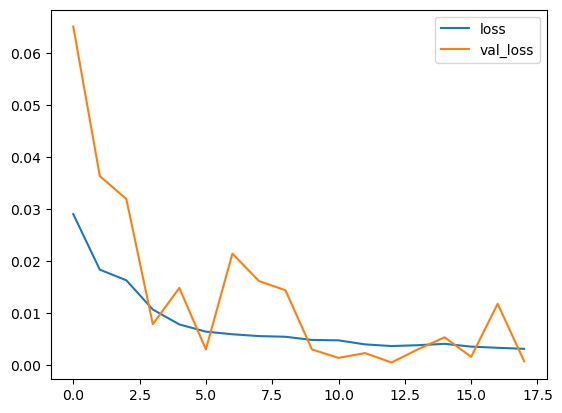

In [35]:
# Plot losses in the dataframe.

losses.plot();

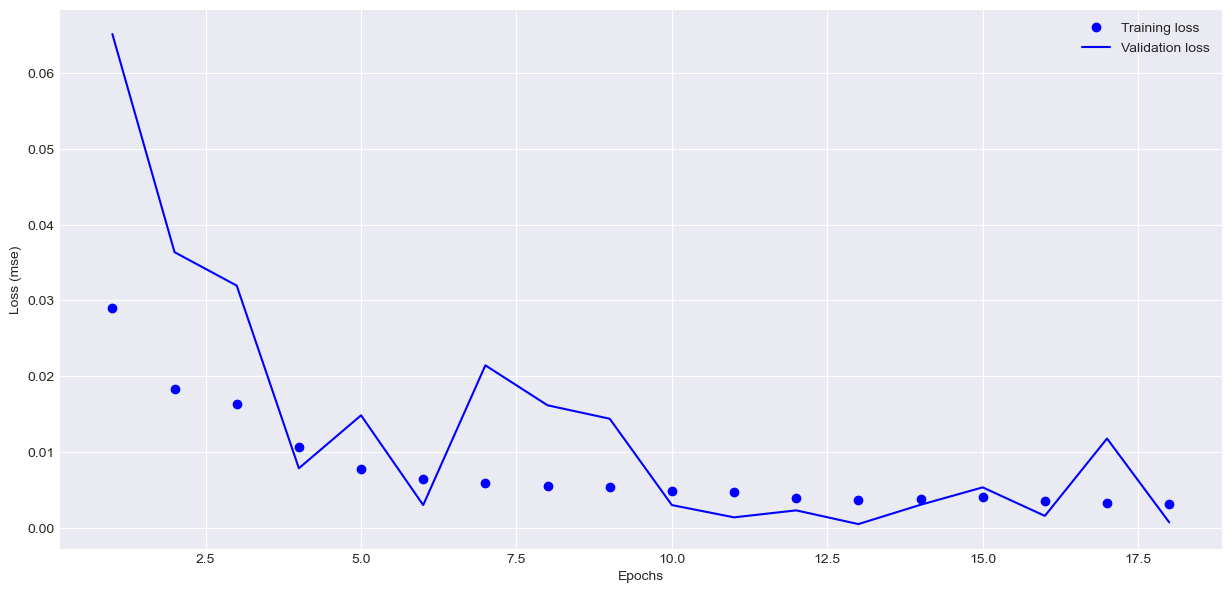

In [36]:
# printing Loss for the neural network training process

history_dict = history.history
plt.style.use('seaborn-darkgrid')

acc_values = history_dict['loss']
val_acc_values = history_dict['val_loss']
epochs = range(1, len(acc_values) + 1)

plt.figure(num=1, figsize=(15,7))
plt.plot(epochs, acc_values, 'bo', label='Training loss')
plt.plot(epochs, val_acc_values, 'b', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (mse)')
plt.legend()

plt.show()

## Evaluate on Test Data

In [37]:
first_eval_batch = scaled_train[-length:]
first_eval_batch

array([[0.49122861],
       [0.48367504],
       [0.52421767],
       [0.55939571],
       [0.88077694],
       [0.38920919],
       [0.41131494],
       [0.64297826],
       [0.62753199],
       [0.71296439],
       [0.67387082],
       [0.69240018]])

In [38]:
n_input = 12
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))
first_eval_batch

array([[[0.49122861],
        [0.48367504],
        [0.52421767],
        [0.55939571],
        [0.88077694],
        [0.38920919],
        [0.41131494],
        [0.64297826],
        [0.62753199],
        [0.71296439],
        [0.67387082],
        [0.69240018]]])

In [39]:
model.predict(first_eval_batch)

1/1 [==============================] - 0s 140ms/step


array([[0.5475486]], dtype=float32)

In [40]:
scaled_test[0]

array([0.68759057])

## Try predicting the series!

In [61]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

current_batch

array([[[0.49122861],
        [0.48367504],
        [0.52421767],
        [0.55939571],
        [0.88077694],
        [0.38920919],
        [0.41131494],
        [0.64297826],
        [0.62753199],
        [0.71296439],
        [0.67387082],
        [0.69240018]]])

In [62]:
for i in range(len(test)):
    
    print(i)
    
    # get prediction 1 time stamp ahead ([0] is for 
    # grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    print(current_pred)
    
    # store prediction
    test_predictions.append(current_pred) 
    print(test_predictions)
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    print(current_batch)

0
1/1 [==============================] - 0s 18ms/step
[0.5484994]
[array([0.5484994], dtype=float32)]
[[[0.48367504]
  [0.52421767]
  [0.55939571]
  [0.88077694]
  [0.38920919]
  [0.41131494]
  [0.64297826]
  [0.62753199]
  [0.71296439]
  [0.67387082]
  [0.69240018]
  [0.54849941]]]
1
1/1 [==============================] - 0s 16ms/step
[0.53870046]
[array([0.5484994], dtype=float32), array([0.53870046], dtype=float32)]
[[[0.52421767]
  [0.55939571]
  [0.88077694]
  [0.38920919]
  [0.41131494]
  [0.64297826]
  [0.62753199]
  [0.71296439]
  [0.67387082]
  [0.69240018]
  [0.54849941]
  [0.53870046]]]
2
1/1 [==============================] - 0s 16ms/step
[0.57039607]
[array([0.5484994], dtype=float32), array([0.53870046], dtype=float32), array([0.57039607], dtype=float32)]
[[[0.55939571]
  [0.88077694]
  [0.38920919]
  [0.41131494]
  [0.64297826]
  [0.62753199]
  [0.71296439]
  [0.67387082]
  [0.69240018]
  [0.54849941]
  [0.53870046]
  [0.57039607]]]
3
1/1 [==============================]

1/1 [==============================] - 0s 17ms/step
[1.1140019]
[array([0.5484994], dtype=float32), array([0.53870046], dtype=float32), array([0.57039607], dtype=float32), array([0.64005566], dtype=float32), array([0.9806017], dtype=float32), array([0.46140015], dtype=float32), array([0.48712626], dtype=float32), array([0.67798007], dtype=float32), array([0.674839], dtype=float32), array([0.7848852], dtype=float32), array([0.74946207], dtype=float32), array([0.77740276], dtype=float32), array([0.62533164], dtype=float32), array([0.61374736], dtype=float32), array([0.6425989], dtype=float32), array([0.7454477], dtype=float32), array([1.1140019], dtype=float32)]
[[[0.46140015]
  [0.48712626]
  [0.67798007]
  [0.67483902]
  [0.78488523]
  [0.74946207]
  [0.77740276]
  [0.62533164]
  [0.61374736]
  [0.64259893]
  [0.7454477 ]
  [1.11400187]]]
17
1/1 [==============================] - 0s 17ms/step
[0.5344475]
[array([0.5484994], dtype=float32), array([0.53870046], dtype=float32), array([0.5

In [41]:
#for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for 
    # grabbing just the number instead of [array])
#    current_pred = model.predict(current_batch)[0]
    
    # store prediction
#    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
#    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 17ms/step


In [72]:
test_predictions

[array([0.5484994], dtype=float32),
 array([0.53870046], dtype=float32),
 array([0.57039607], dtype=float32),
 array([0.64005566], dtype=float32),
 array([0.9806017], dtype=float32),
 array([0.46140015], dtype=float32),
 array([0.48712626], dtype=float32),
 array([0.67798007], dtype=float32),
 array([0.674839], dtype=float32),
 array([0.7848852], dtype=float32),
 array([0.74946207], dtype=float32),
 array([0.77740276], dtype=float32),
 array([0.62533164], dtype=float32),
 array([0.61374736], dtype=float32),
 array([0.6425989], dtype=float32),
 array([0.7454477], dtype=float32),
 array([1.1140019], dtype=float32),
 array([0.5344475], dtype=float32)]

## Inverse Transformations and Compare

In [73]:
# Отменить масштабирование

scaler.inverse_transform?

In [74]:
true_predictions = scaler.inverse_transform(test_predictions)

In [75]:
true_predictions

array([[20551.57821363],
       [20233.74946511],
       [21261.79639137],
       [23521.20521641],
       [34566.81704646],
       [17726.51390588],
       [18560.9402754 ],
       [24751.28341949],
       [24649.40360641],
       [28218.75235981],
       [27069.8021782 ],
       [27976.05847514],
       [23043.6317513 ],
       [22667.89556718],
       [23603.69619793],
       [26939.5959956 ],
       [38893.65065849],
       [20095.80437607]])

In [76]:
# IGNORE WARNINGS

test['Predictions'] = true_predictions

C:\Users\vital\AppData\Local\Temp\ipykernel_18912\3095654106.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


## Check and plot predictions

In [78]:
test

,Sales,Predictions
DATE,,
2021-08-01,25063,20551.578214
2021-09-01,22592,20233.749465
2021-10-01,24366,21261.796391
2021-11-01,28725,23521.205216
2021-12-01,39375,34566.817046
2022-01-01,18113,17726.513906
2022-02-01,20509,18560.940275
2022-03-01,25622,24751.283419
2022-04-01,25904,24649.403606


<AxesSubplot:xlabel='DATE'>

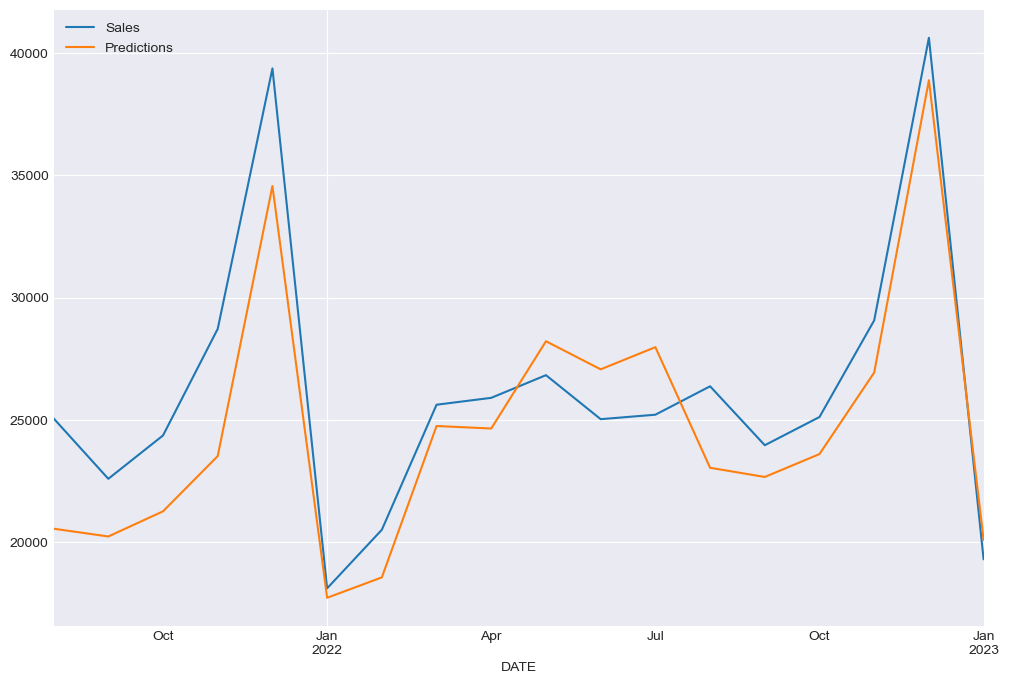

In [79]:
test.plot(figsize=(12,8))

# Retrain and Forecasting

In [80]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [81]:
full_scaler.fit_transform?

In [84]:
print(scaled_full_data.max())
print(scaled_full_data.min())

1.0
0.0


In [94]:
length = 12 # Length of the output sequences (in number of timesteps)

generator = TimeseriesGenerator(scaled_full_data, 
                                scaled_full_data, length=length, batch_size=1)

In [95]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))

In [96]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100)               40800     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [97]:
model.compile(optimizer='adam', loss='mse')

In [98]:
early_stop = EarlyStopping(monitor='loss',patience=5)

In [99]:
# fit model
# IGNORE THE WARNING

history_2 =  model.fit(generator, epochs=30, callbacks=[early_stop])

Epoch 1/30
361/361 [==============================] - 2s 3ms/step - loss: 0.0191
Epoch 2/30
361/361 [==============================] - 1s 3ms/step - loss: 0.0122
Epoch 3/30
361/361 [==============================] - 1s 3ms/step - loss: 0.0101
Epoch 4/30
361/361 [==============================] - 1s 3ms/step - loss: 0.0062
Epoch 5/30
361/361 [==============================] - 1s 3ms/step - loss: 0.0073
Epoch 6/30
361/361 [==============================] - 1s 3ms/step - loss: 0.0046
Epoch 7/30
361/361 [==============================] - 1s 3ms/step - loss: 0.0048
Epoch 8/30
361/361 [==============================] - 1s 3ms/step - loss: 0.0041
Epoch 9/30
361/361 [==============================] - 1s 3ms/step - loss: 0.0039
Epoch 10/30
361/361 [==============================] - 1s 3ms/step - loss: 0.0035
Epoch 11/30
361/361 [==============================] - 1s 3ms/step - loss: 0.0033
Epoch 12/30
361/361 [==============================] - 1s 3ms/step - loss: 0.0037
Epoch 13/30
361/361 [====

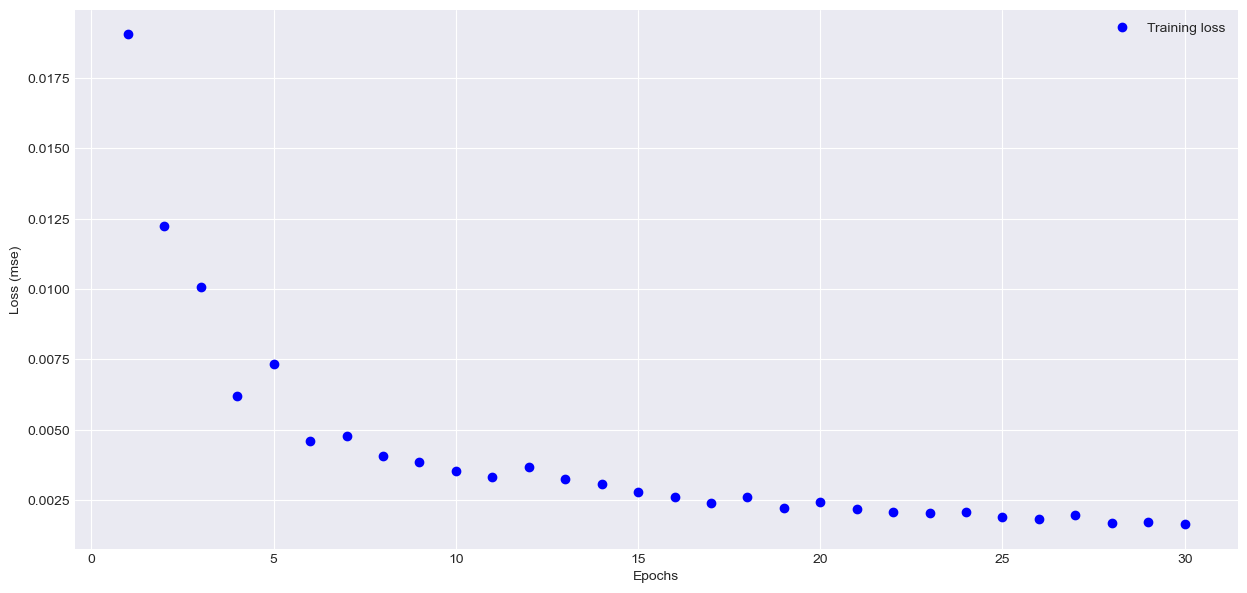

In [100]:
# printing Loss for the neural network training process

history_dict = history_2.history
plt.style.use('seaborn-darkgrid')

acc_values = history_dict['loss']
#val_acc_values = history_dict['val_loss']
epochs = range(1, len(acc_values) + 1)

plt.figure(num=1, figsize=(15,7))
plt.plot(epochs, acc_values, 'bo', label='Training loss')
plt.plot(epochs, val_acc_values, 'b', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (mse)')
plt.legend()

plt.show()

In [50]:
# fit model
#model.fit(generator,epochs=8)

Epoch 1/8
361/361 [==============================] - 2s 3ms/step - loss: 0.0172
Epoch 2/8
361/361 [==============================] - 1s 3ms/step - loss: 0.0127
Epoch 3/8
361/361 [==============================] - 1s 4ms/step - loss: 0.0087
Epoch 4/8
361/361 [==============================] - 1s 3ms/step - loss: 0.0072
Epoch 5/8
361/361 [==============================] - 1s 3ms/step - loss: 0.0052
Epoch 6/8
361/361 [==============================] - 1s 3ms/step - loss: 0.0050
Epoch 7/8
361/361 [==============================] - 1s 3ms/step - loss: 0.0043
Epoch 8/8
361/361 [==============================] - 1s 3ms/step - loss: 0.0042


In [101]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for 
    # grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 17ms/step


In [102]:
forecast = scaler.inverse_transform(forecast)

In [103]:
forecast

array([[16266.55267587],
       [17558.16030836],
       [18556.85429519],
       [20437.21329993],
       [20369.81734252],
       [20333.75786638],
       [21482.15706414],
       [20326.26835263],
       [20260.18702334],
       [22862.38513178],
       [31600.64287579],
       [18167.13665432]])

### Creating new timestamp index with pandas.

In [104]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2022-09-01,23966
2022-10-01,25120
2022-11-01,29072


### Forecast for next 12 months

In [109]:
forecast_index = pd.date_range(start='2023-02-01', periods=periods, freq='MS')
forecast_index

DatetimeIndex(['2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01',
               '2023-06-01', '2023-07-01', '2023-08-01', '2023-09-01',
               '2023-10-01', '2023-11-01', '2023-12-01', '2024-01-01'],
              dtype='datetime64[ns]', freq='MS')

In [108]:
pd.date_range?

In [110]:
forecast_df = pd.DataFrame(data=forecast, index=forecast_index,
                           columns=['Forecast'])

In [111]:
forecast_df

,Forecast
2023-02-01,16266.552676
2023-03-01,17558.160308
2023-04-01,18556.854295
2023-05-01,20437.213300
2023-06-01,20369.817343
2023-07-01,20333.757866
2023-08-01,21482.157064
2023-09-01,20326.268353
2023-10-01,20260.187023
2023-11-01,22862.385132


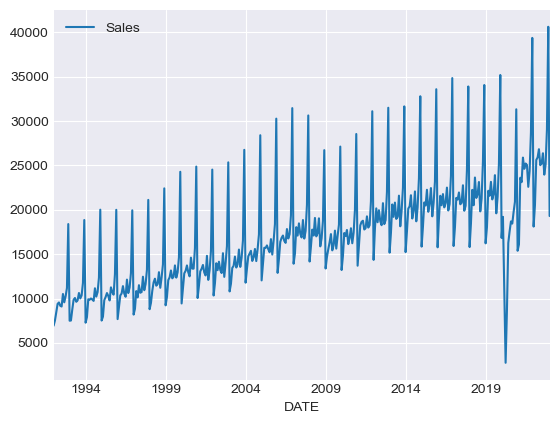

In [113]:
# Plot sales - Values in dataframe

df.plot();

<AxesSubplot:>

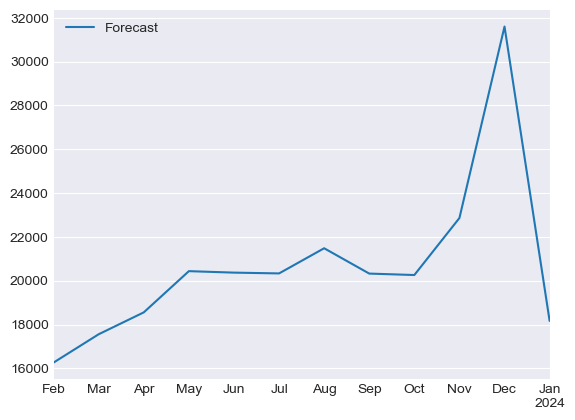

In [114]:
# Plot forecast - Values in forecast_df

forecast_df.plot()

### Joining pandas plots

https://stackoverflow.com/questions/13872533/plot-different-dataframes-in-the-same-figure

<AxesSubplot:xlabel='DATE'>

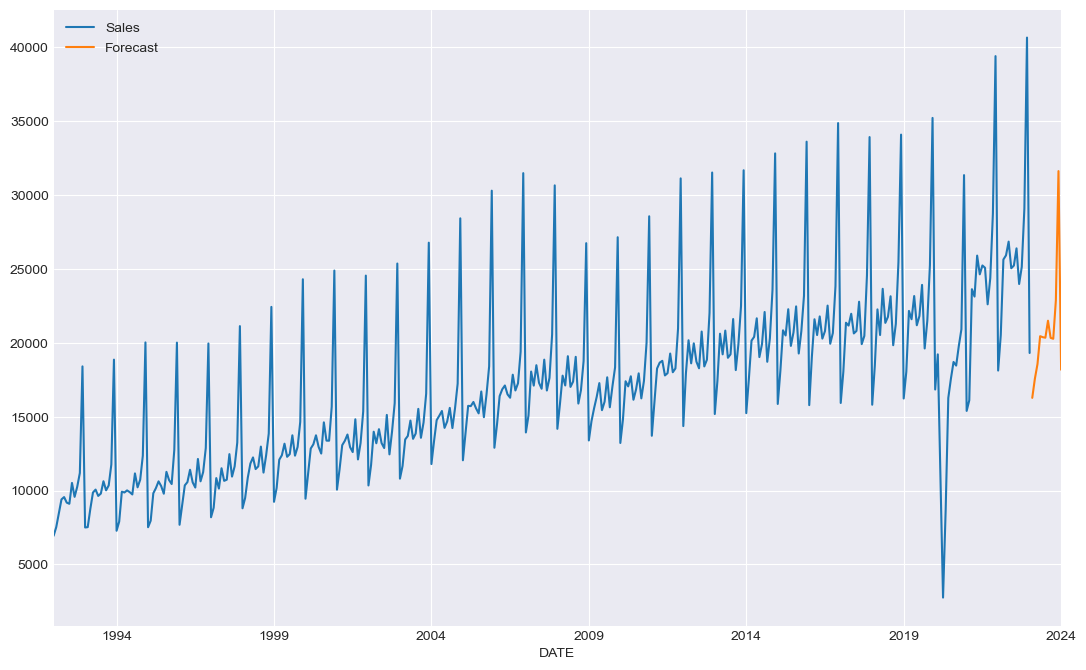

In [120]:
ax = df.plot(figsize=(13,8))
forecast_df.plot(ax=ax)

(612.0, 648.0)

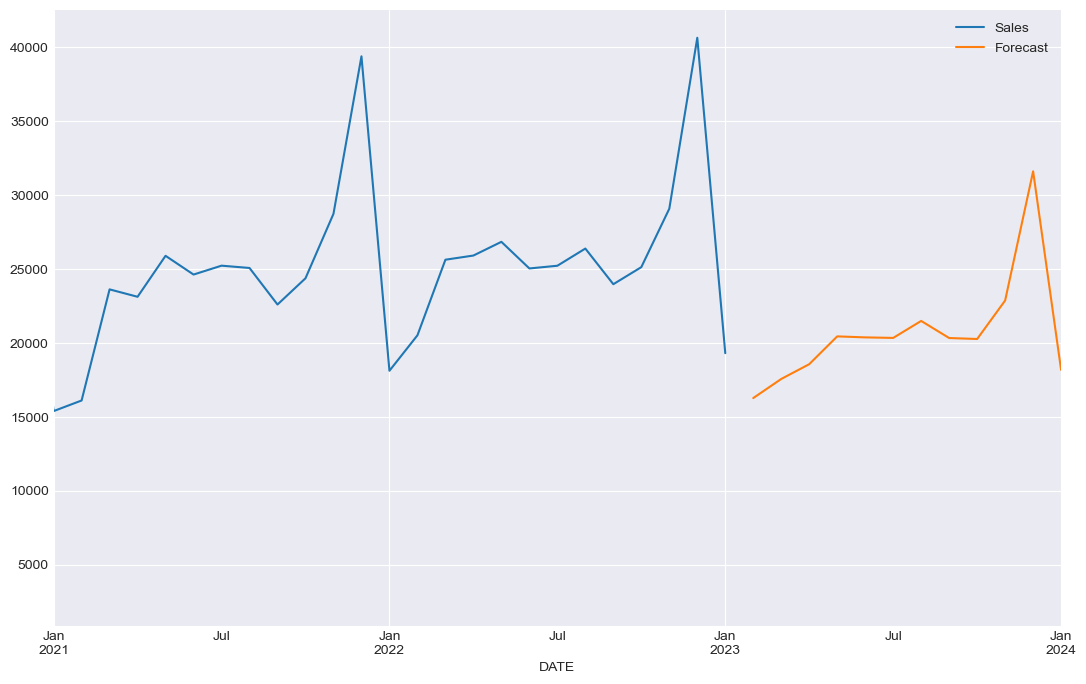

In [121]:
ax = df.plot(figsize=(13,8))
forecast_df.plot(ax=ax)
plt.xlim('2021-01-01','2024-01-01')

### Cecking Forecast for last 12 months

In [122]:
forecast_index = pd.date_range(start='2022-02-01', periods=periods, freq='MS')
forecast_index

DatetimeIndex(['2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01',
               '2022-06-01', '2022-07-01', '2022-08-01', '2022-09-01',
               '2022-10-01', '2022-11-01', '2022-12-01', '2023-01-01'],
              dtype='datetime64[ns]', freq='MS')

In [123]:
forecast_df = pd.DataFrame(data=forecast, index=forecast_index,
                           columns=['Forecast'])

(576.0, 636.0)

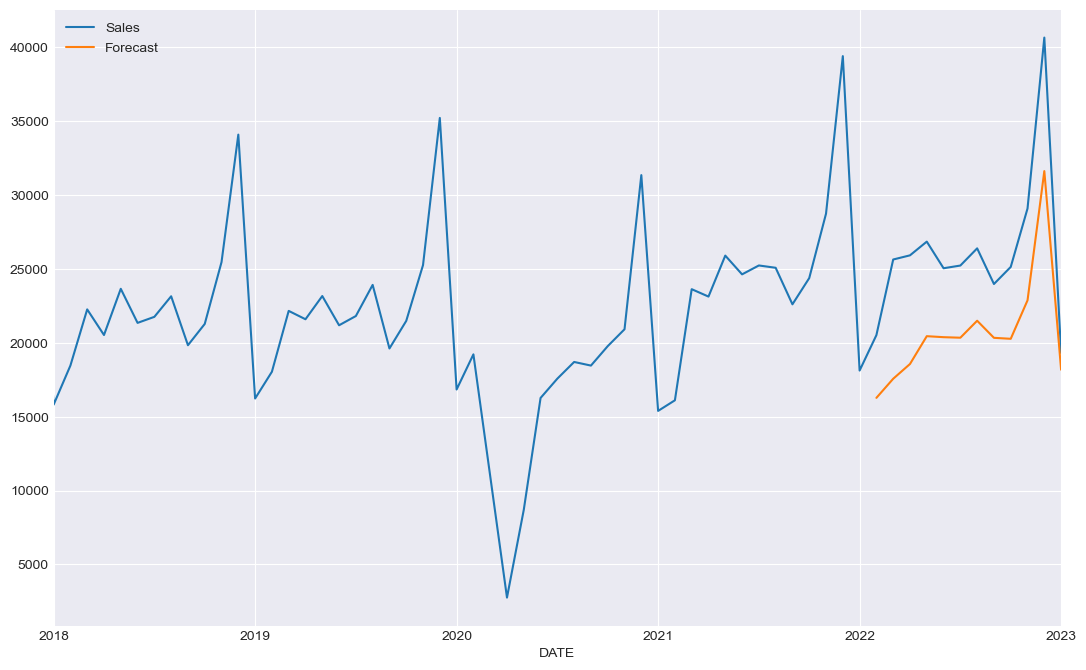

In [126]:
ax = df.plot(figsize=(13,8))
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2023-01-01')